In [1]:
from cltk.corpus.utils.importer import CorpusImporter
from cltk.corpus.readers import get_corpus_reader
from cltk.tag.pos import POSTag
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
from cltk.tokenize.latin.sentence import SentenceTokenizer
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import re
from datetime import datetime

In [2]:
import json
from datetime import datetime
# import time
from itertools import zip_longest, islice

In [107]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import cProfile
# import pstats
# from pstats import SortKey
# import sys
# import os
# os.environ["PYTHONTRACEMALLOC"] = '10'
# import tracemalloc

In [4]:
# tracemalloc.start()

In [5]:
pd.set_option("display.max_rows", 40)

In [6]:
corpus_importer = CorpusImporter('latin')

corpus_importer.import_corpus('latin_models_cltk')
corpus_importer.import_corpus('latin_text_perseus')

reader = get_corpus_reader(language='latin', corpus_name='latin_text_perseus')

In [7]:
# perseus_sents = list(reader.sents())

# len(perseus_sents)

In [8]:
# with open('out.json', 'w', encoding='utf-8') as f:
#     json.dump(docs, f, ensure_ascii=False, indent=4)

In [9]:
tagger = POSTag('latin')
lemmatizer = BackoffLatinLemmatizer()

sent_tokenizer = SentenceTokenizer(strict=True)

In [10]:
# def get_categories():
pos = {
    'n': 'noun',
    'v': 'verb',
    't': 'participle',
    'a': 'adjective',
    'd': 'adverb',
    'c': 'conjunction',
    'r': 'preposition',
    'p': 'pronoun',
    'm': 'numeral',
    'i': 'interjection',
    'e': 'exclamation',
    'u': 'punctuation'
}

person = {
    '1': 'first person',
    '2': 'second person',
    '3': 'third person'
}

number = {
    's': 'singular',
    'p': 'plural'
}

tense = {
    'p': 'present',
    'i': 'imperfect',
    'r': 'perfect',
    'l': 'pluperfect',
    't': 'future perfect',
    'f': 'future',
}

mood = {
    'i': 'indicative',
    's': 'subjunctive',
    'n': 'infinitive',
    'm': 'imperative',
    'p': 'participle',
    'd': 'gerund',
    'g': 'gerundive',
    'u': 'supine',
}

voice = {
    'a': 'active',
    'p': 'passive',
}

gender = {
    'm': 'masculine',
    'f': 'feminine',
    'n': 'neuter',
}

case = {
    'n': 'nominative',
    'g': 'genitive',
    'd': 'dative',
    'a': 'accusative',
    'b': 'ablative',
    'v': 'vocative',
    'l': 'locative',
}

degree = {
    'c': 'comparative',
    's': 'superlative',
}

categories = {'pos': pos, 'person': person, 'number': number, 'tense': tense,
              'mood': mood, 'voice': voice, 'gender': gender, 'case': case,
              'degree': degree}
categories_names = {1: 'pos', 2: 'person', 3: 'number', 4: 'tense',
                    5: 'mood', 6: 'voice', 7: 'gender', 8: 'case',
                    9: 'degree'}
    
#     return categories, categories_names

In [11]:
def convert_analysis_to_dict(analysis, keep_empty=True):   
    dict_analysis = {}
    
    for i, cat_value_letter in enumerate(analysis, start=1):
        cat_name = categories_names[i]
        if cat_value_letter == '-':
            if keep_empty:
                dict_analysis[cat_name] = 'N/A'
            continue
        try:    
            cat_value_word = categories[cat_name][cat_value_letter.lower()]
            dict_analysis[cat_name] = cat_value_word
        except KeyError as k_e:
            print(k_e)
            print(cat_value_letter, analysis)
            
    return dict_analysis

In [12]:
def is_foreign_lang_in_sent(sent):
    # истинно для открывков вроде
    # h(\ to/sa fa/rmaka h)/dh, o(/sa tre/fei eu)rei=a xqw/n
    foreign_chars = set(['\\', '/', '|', '='])
#     foreign_chars_code = re.compile(r'\\\w+|\w\\|/\w|\w/|\||=')
#     return bool(re.search(foreign_chars_code, sent))
    return any(word in sent for word in foreign_chars)

Функция находит в предложении предлоги, употребляющиеся с аблативом, и стоящие после них слова. Если есть что-то необычное, например, слово не в аблативе, или не имеющее падежа, то оно возвращается.

Сперва сделаем разборы слов предложения, заодно они токенизируются. Все слова на время сохраним в `words_in_sent`. Если среди них нет ни одного нужного предлога, функция сразу вернёт `None`. Если предлоги есть, то идёт проход по всем словам, проверка каждого слова и если это нужный предлог, то проверяется следующее слово. Если предлог - последнее слово в предложении (вернее в клаузе), то результат обозначается специальным маркером `%END%`, в противном случае анализируется следующее слово.

In [24]:
def get_non_ablative_after_preposition(sent, context_size=8):   
    
    # pro вроде иногда с Acc
    abl_preps = set(('a', 'ab', 'de', 'cum', 'ex', 'e', 'sine', 'pro', 'prae'))
    results = {'sentence': None, 'strange_pairs': [], 'contexts': []}
    
    tagged_words =  tagger.tag_ngram_123_backoff(sent)
    words_number = len(tagged_words)
    
    words_in_sent, _ = zip(*tagged_words)
    if not any(prep in words_in_sent for prep in abl_preps):
        return None
    
    for i, (word, analysis) in enumerate(tagged_words):        
        if analysis is None:
            continue
        
        is_needed_prep = analysis[0] == 'R' and word in abl_preps
        if not is_needed_prep:
            continue
        
        verbose_analysis = convert_analysis_to_dict(analysis)
        verbose_analysis['word'] = word
        [(_, word_lemma)] = lemmatizer.lemmatize([word])
        verbose_analysis['lemma'] = word_lemma

        is_last = i == words_number - 1        
        if is_last:
            results['sentence'] = sent
            results['strange_pairs'].append(
                (verbose_analysis,
                 {cat_name: '%END%' for cat_name in list(categories.keys())+['word', 'lemma']}))
            results['contexts'].append(words_in_sent[max(i-context_size, 0):])
            
        else:
            next_word, next_word_analysis = tagged_words[i+1]
            if next_word_analysis is None:
                # может всё-таки брать такие слова?
                continue
                
            if next_word_analysis[8-1].lower() != 'b':
                next_word_verbose_analysis = convert_analysis_to_dict(
                    next_word_analysis)
                next_word_verbose_analysis['word'] = next_word
                [(_, next_word_lemma)] = lemmatizer.lemmatize([next_word])
                next_word_verbose_analysis['lemma'] = next_word_lemma
                
                results['sentence'] = sent
                results['strange_pairs'].append((verbose_analysis,
                                                next_word_verbose_analysis))
                results['contexts'].append(words_in_sent[max(i-context_size, 0):min(i+context_size, words_number)])
            
    if results['sentence'] is None:
        return None
    return results

In [14]:
def flatten_dict_into_str(iter_):
    if isinstance(iter_, str):
        yield iter_
    else:
        try:
            for i, obj in iter_.items():
                yield from flatten_dict_into_str(obj)
        except:
            try:
                for obj in iter_:
                    yield from flatten_dict_into_str(obj)
            except:
                yield iter_

Функция `grouper()` из [itertools recipes](https://docs.python.org/library/itertools.html#itertools-recipes)

> this is feeding the same iterator to `izip_longest` multiple times, causing it to consume successive values of the same sequence rather than striped values from separate sequences. [StackOverflow](https://stackoverflow.com/questions/434287/what-is-the-most-pythonic-way-to-iterate-over-a-list-in-chunks)

Ещё вариант:

```python
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, > len(seq), size))
```



In [15]:
def grouper(iterable, chunk_size, fillvalue=None):
    args = [iter(iterable)] * chunk_size
    return zip_longest(*args, fillvalue=fillvalue)

In [16]:
def analyse_document(doc):
    analysis_for_doc = {'author': doc['author'], 'title': doc['originalTitle'],
                       'sentences': []}
    
    text = ' '.join([str(el) for el in flatten_dict_into_str(doc['text'])])
    sentences = sent_tokenizer.tokenize(text)
    
    ### chunking
    num_of_sent = len(sentences)
    chunk_size = 300
    if num_of_sent >= 2 * chunk_size:
        sentences = grouper(sentences, chunk_size)
    else:
        sentences = [sentences]
    
    tqdm.write('Now analyzing ' + doc['author'] + ' ' + doc['originalTitle'])
    tqdm.write('Num of sentences: ' + str(num_of_sent))
    tqdm.write(str(type(sentences)))
    
    for sent_chunk in tqdm(sentences):
        for sent in sent_chunk:
            # если в предложении вкрапления греческого, которые в корпусе 
            # записаны очень странно, то пропускаем это предложение
            # также пропускаем пустое предложение, которое могло появиться из-за
            # fillvalue в итераторе 
            if sent is None or is_foreign_lang_in_sent(sent):
                continue

            sent_data = get_non_ablative_after_preposition(sent)
            if sent_data is None:
                continue

            analysis_for_doc['sentences'].append(sent_data)
    
    if not analysis_for_doc['sentences']:
        return None
    
    return analysis_for_doc

    
#     for sent in tqdm(sentences):
#         # если в предложении вкрапления греческого, которые в корпусе 
#         # записаны очень странно, то пропускаем это предложение 
#         if is_foreign_lang_in_sent(sent):
#             continue
        
#         sent_data = get_non_ablative_after_preposition(sent)
#         if sent_data is None:
#             continue
   
#         analysis_for_doc['sentences'].append(sent_data)
    
#     return analysis_for_doc

Выше в качестве `docs` взят генератор. Это довольно быстро по времени, и экономнее по памяти. **NB**: характерные гребни на графике использования RAM когда выполняется цикл, видимо всё-таки из-за кода в функции выше:

```python
text = ' '.join([str(el) for el in flatten_dict_into_str(doc['text'])])
sentences = sent_tokenizer.tokenize(text)
```

In [17]:
def get_data_from_x_docs(docs, count_doc, start=0):
    # count = 3000
    # results = []
    # for sent in tqdm(perseus_sents[:count]):
    #     result = get_non_ablative_after_preposition(sent)
    #     if result is not None:
    #         results.append(result)

    results = []

#     for doc in tqdm(docs[:count_doc]):
    for doc in tqdm(islice(docs, start, count_doc)):
        result = analyse_document(doc)
        if result is not None:
            results.append(result)
            
    return results

In [18]:
# tracemalloc.start()

In [19]:
# ds = reader.docs()
# print(len(list(ds))) # 293

In [20]:
docs = reader.docs()

In [21]:
# sys.getsizeof(docs)

In [22]:
# time = datetime.now().strftime('%H.%M.%S-%d-%m')
# STATS_FILENAME = 'runstats.'.format(time)
# cProfile.run('get_data_from_x_docs(count_doc)', STATS_FILENAME) 
# results = get_data_from_x_docs(count_doc)
# start = time.time()
# for i in range(10):
count_doc = 293
results = get_data_from_x_docs(docs, count_doc)
time = datetime.now.strftime('%H.%M.%S-%d-%m')
with open('out_x{}-{}.json'.format(count_doc, time), 'w', encoding='utf-8') as f:
    json.dump(docs, f, ensure_ascii=False, indent=4)
# end = time.time()

Now analyzing ammianus marcellinus. Rerum Gestarum
Num of sentences: 5006
<class 'itertools.zip_longest'>



Now analyzing apuleius Apologia
Num of sentences: 1315
<class 'itertools.zip_longest'>



Now analyzing apuleius Florida
Num of sentences: 389
<class 'list'>



Now analyzing apuleius Metamorphoses
Num of sentences: 2674
<class 'itertools.zip_longest'>



Now analyzing ausonius, decimus magnus. Bissula
Num of sentences: 23
<class 'list'>



Now analyzing ausonius, decimus magnus. Caesares
Num of sentences: 73
<class 'list'>



Now analyzing ausonius, decimus magnus. Commemoratio Professorum Burdigalensium
Num of sentences: 169
<class 'list'>



Now analyzing ausonius, decimus magnus. De Herediolo
Num of sentences: 20
<class 'list'>



Now analyzing ausonius, decimus magnus. Eclogarum Liber
Num of sentences: 214
<class 'list'>



Now analyzing ausonius, decimus magnus. Ephemeris
Num of sentences: 105
<class 'list'>



Now analyzing ausonius, decimus magnus. Epicedion in Patrem
Num of sentences: 38
<class 'list'>



Now analyzing ausonius, decimus magnus. Epigrammaton Liber
Num of sentences: 436
<class 'list'>



Now analyzing ausonius, decimus magnus. Epistulae
Num of sentences: 603
<class 'itertools.zip_longest'>



Now analyzing ausonius, decimus magnus. Epitaphia
Num of sentences: 113
<class 'list'>



Now analyzing ausonius, decimus magnus. Genethliacon ad Ausonium Nepotem
Num of sentences: 10
<class 'list'>



Now analyzing ausonius, decimus magnus. Gratiarum Actio
Num of sentences: 308
<class 'list'>



Now analyzing ausonius, decimus magnus. Griphus Ternarii Numeri
Num of sentences: 76
<class 'list'>



Now analyzing ausonius, decimus magnus. Liber Protrepticus ad Nepotem
Num of sentences: 47
<class 'list'>



Now analyzing ausonius, decimus magnus. Mosella
Num of sentences: 174
<class 'list'>



Now analyzing ausonius, decimus magnus. Oratio Versibus Rhopalicis
Num of sentences: 20
<class 'list'>



Now analyzing ausonius, decimus magnus. Ordo Urbium Nobilium
Num of sentences: 65
<class 'list'>



Now analyzing ausonius, decimus magnus. Parentalia
Num of sentences: 158
<class 'list'>



Now analyzing ausonius, decimus magnus. Praefatiunculae
Num of sentences: 36
<class 'list'>



Now analyzing ausonius, decimus magnus. Precationes
Num of sentences: 32
<class 'list'>



Now analyzing ausonius, decimus magnus. Technopaegnion
Num of sentences: 146
<class 'list'>



Now analyzing ausonius, decimus magnus. Versus Paschales Prosodic
Num of sentences: 8
<class 'list'>



Now analyzing boethius d. 524 De consolatione philosophiae
Num of sentences: 1797
<class 'itertools.zip_longest'>



Now analyzing boethius d. 524 De Fide Catholica
Num of sentences: 74
<class 'list'>



Now analyzing boethius d. 524 Liber De Persona et Duabus Naturis Contra Eutychen Et Nestorium
Num of sentences: 318
<class 'list'>



Now analyzing boethius d. 524 Quomodo Substantiae in Eo Quod Sint Bonae Sint Cum Non Sint Substanialia Bona
Num of sentences: 113
<class 'list'>



Now analyzing boethius d. 524 Quomodo Trinitas Unus Deus Ac Non Tres Dii (De Trinitate)
Num of sentences: 173
<class 'list'>



Now analyzing boethius d. 524 Utrum Pater Et Filius Ac Spiritus Sanctus De Divinitate Substantialiter Praedicentur Liber
Num of sentences: 35
<class 'list'>



Now analyzing caesar, julius. Gallic War
Num of sentences: 2857
<class 'itertools.zip_longest'>



Now analyzing celsus, aulus cornelius. De Medicina
Num of sentences: 11180
<class 'itertools.zip_longest'>



Now analyzing cicero Academica
Num of sentences: 210
<class 'list'>



Now analyzing cicero Orationes de Lege Agraria
Num of sentences: 837
<class 'itertools.zip_longest'>



Now analyzing cicero Brutus
Num of sentences: 1604
<class 'itertools.zip_longest'>



Now analyzing cicero De Amicitia
Num of sentences: 574
<class 'list'>



Now analyzing cicero De Divinatione
Num of sentences: 1962
<class 'itertools.zip_longest'>



Now analyzing cicero De Fato
Num of sentences: 347
<class 'list'>



Now analyzing cicero de Finibus Bonorum et Malorum
Num of sentences: 2726
<class 'itertools.zip_longest'>



Now analyzing cicero De Inventione
Num of sentences: 2228
<class 'itertools.zip_longest'>



Now analyzing cicero de Natura Deorum
Num of sentences: 2137
<class 'itertools.zip_longest'>



Now analyzing cicero De Officiis
Num of sentences: 2013
<class 'itertools.zip_longest'>



Now analyzing cicero De Optimo Genere Oratorum
Num of sentences: 105
<class 'list'>



Now analyzing cicero De Republica
Num of sentences: 1227
<class 'itertools.zip_longest'>



Now analyzing cicero De Senectute
Num of sentences: 526
<class 'list'>



Now analyzing cicero In Caecilium
Num of sentences: 330
<class 'list'>



Now analyzing cicero Pro Archia
Num of sentences: 141
<class 'list'>



Now analyzing cicero For Marcus Caelius
Num of sentences: 521
<class 'list'>



Now analyzing cicero Pro Fonteio
Num of sentences: 230
<class 'list'>



Now analyzing cicero Pro P. Quinctio
Num of sentences: 638
<class 'itertools.zip_longest'>



Now analyzing cicero Pro Roscio comoedo
Num of sentences: 465
<class 'list'>



Now analyzing cicero Pro S. Roscio Amerino
Num of sentences: 923
<class 'itertools.zip_longest'>



Now analyzing cicero Pro Sulla
Num of sentences: 494
<class 'list'>



Now analyzing cicero In Catilinam
Num of sentences: 669
<class 'itertools.zip_longest'>



Now analyzing cicero Pro Cluentio
Num of sentences: 1235
<class 'itertools.zip_longest'>



Now analyzing cicero Pro C. Rabiro perduellionis reo
Num of sentences: 169
<class 'list'>



Now analyzing cicero Pro Murena
Num of sentences: 639
<class 'itertools.zip_longest'>



Now analyzing cicero Pro Flacco
Num of sentences: 814
<class 'itertools.zip_longest'>



Now analyzing cicero Post reditum in senatu
Num of sentences: 183
<class 'list'>



Now analyzing cicero Letters to Atticus
Num of sentences: 10926
<class 'itertools.zip_longest'>



Now analyzing cicero Letters to Brutus
Num of sentences: 666
<class 'itertools.zip_longest'>



Now analyzing cicero Letters to his brother Quintus
Num of sentences: 1240
<class 'itertools.zip_longest'>



Now analyzing cicero Letters to his Friends
Num of sentences: 7039
<class 'itertools.zip_longest'>



Now analyzing cicero Lucullus
Num of sentences: 1131
<class 'itertools.zip_longest'>



Now analyzing cicero Pro A. Caecina
Num of sentences: 620
<class 'itertools.zip_longest'>



Now analyzing cicero Pro Tullio
Num of sentences: 229
<class 'list'>



Now analyzing cicero On Oratory
Num of sentences: 3142
<class 'itertools.zip_longest'>



Now analyzing cicero Pro lege manilia
Num of sentences: 299
<class 'list'>



Now analyzing cicero In Verrem
Num of sentences: 6622
<class 'itertools.zip_longest'>



Now analyzing cicero Orator
Num of sentences: 1216
<class 'itertools.zip_longest'>



Now analyzing cicero Paradoxa Stoicorum
Num of sentences: 316
<class 'list'>



Now analyzing cicero Partitiones Oratoriae
Num of sentences: 648
<class 'itertools.zip_longest'>



Now analyzing cicero Timaeus
Num of sentences: 193
<class 'list'>



Now analyzing cicero Post reditum ad populum
Num of sentences: 108
<class 'list'>



Now analyzing cicero Topica
Num of sentences: 568
<class 'list'>



Now analyzing cicero Tusculanae Disputationes
Num of sentences: 3685
<class 'itertools.zip_longest'>



Now analyzing claudianus, claudius. Carminum minorum corpusculum
Num of sentences: 612
<class 'itertools.zip_longest'>



Now analyzing claudianus, claudius. de bello Gildonico
Num of sentences: 320
<class 'list'>



Now analyzing claudianus, claudius. de Bello Gothico
Num of sentences: 252
<class 'list'>



Now analyzing claudianus, claudius. de consulatu Stilichonis
Num of sentences: 591
<class 'list'>



Now analyzing claudianus, claudius. de raptu Proserpinae
Num of sentences: 644
<class 'itertools.zip_longest'>



Now analyzing claudianus, claudius. Epithalamium de nuptiis Honorii Augusti
Num of sentences: 216
<class 'list'>



Now analyzing claudianus, claudius. Fescinnina de nuptiis Honorii Augusti
Num of sentences: 47
<class 'list'>



Now analyzing claudianus, claudius. In Eutropium
Num of sentences: 676
<class 'itertools.zip_longest'>



Now analyzing claudianus, claudius. In Rufinum
Num of sentences: 488
<class 'list'>



Now analyzing claudianus, claudius. Panegyricus de quarto consulatu Honorii Augusti
Num of sentences: 375
<class 'list'>



Now analyzing claudianus, claudius. Panegyricus de sexto consulatu Honorii Augusti
Num of sentences: 275
<class 'list'>



Now analyzing claudianus, claudius. Panegyricus de tertio consulatu Honorii Augusti
Num of sentences: 82
<class 'list'>



Now analyzing claudianus, claudius. Panegyricus dictus Manlio Theodoro consuli
Num of sentences: 173
<class 'list'>



Now analyzing claudianus, claudius. Panegyricus dictus Probino et Olybrio consulibus
Num of sentences: 129
<class 'list'>



Now analyzing columella, lucius junius moderatus. Res Rustica
Num of sentences: 5113
<class 'itertools.zip_longest'>



Now analyzing curtius rufus, quintus. Historiarum Alexandri Magni
Num of sentences: 5343
<class 'itertools.zip_longest'>



Now analyzing florus, lucius annaeus. Epitome Rerum Romanorum
Num of sentences: 1789
<class 'itertools.zip_longest'>



Now analyzing gellius, aulus. Noctes Atticae
Num of sentences: 5521
<class 'itertools.zip_longest'>



Now analyzing horace Ars Poetica
Num of sentences: 214
<class 'list'>



Now analyzing horace Carmen Saeculare
Num of sentences: 17
<class 'list'>



Now analyzing horace Epistulae
Num of sentences: 667
<class 'itertools.zip_longest'>



Now analyzing horace Epodi
Num of sentences: 178
<class 'list'>



Now analyzing horace Odes
Num of sentences: 815
<class 'itertools.zip_longest'>



Now analyzing horace Satires
Num of sentences: 1095
<class 'itertools.zip_longest'>



Now analyzing jerome saint d. 419 or 20 Epistolae
Num of sentences: 3272
<class 'itertools.zip_longest'>



Now analyzing juvenal Satires
Num of sentences: 1497
<class 'itertools.zip_longest'>



Now analyzing lucan Civil War
Num of sentences: 4818
<class 'itertools.zip_longest'>



Now analyzing lucretius De Rerum Natura
Num of sentences: 2429
<class 'itertools.zip_longest'>



Now analyzing martial Epigrammata
Num of sentences: 5624
<class 'itertools.zip_longest'>



Now analyzing minucius felix, marcus. Octavius
Num of sentences: 697
<class 'itertools.zip_longest'>



Now analyzing nepos, cornelius. Agesilaus
Num of sentences: 79
<class 'list'>



Now analyzing nepos, cornelius. Alcibiades
Num of sentences: 118
<class 'list'>



Now analyzing nepos, cornelius. Aristides
Num of sentences: 19
<class 'list'>



Now analyzing nepos, cornelius. Atticus
Num of sentences: 198
<class 'list'>



Now analyzing nepos, cornelius. Cato
Num of sentences: 17
<class 'list'>



Now analyzing nepos, cornelius. Chabrias
Num of sentences: 33
<class 'list'>



Now analyzing nepos, cornelius. Cimon
Num of sentences: 32
<class 'list'>



Now analyzing nepos, cornelius. Conon
Num of sentences: 42
<class 'list'>



Now analyzing nepos, cornelius. Datames
Num of sentences: 114
<class 'list'>



Now analyzing nepos, cornelius. De Regibus
Num of sentences: 33
<class 'list'>



Now analyzing nepos, cornelius. Dion
Num of sentences: 89
<class 'list'>



Now analyzing nepos, cornelius. Epaminondas
Num of sentences: 86
<class 'list'>



Now analyzing nepos, cornelius. Eumenes
Num of sentences: 132
<class 'list'>



Now analyzing nepos, cornelius. Hamilcar
Num of sentences: 28
<class 'list'>



Now analyzing nepos, cornelius. Hannibal
Num of sentences: 132
<class 'list'>



Now analyzing nepos, cornelius. Iphicrates
Num of sentences: 24
<class 'list'>



Now analyzing nepos, cornelius. Lysander
Num of sentences: 31
<class 'list'>



Now analyzing nepos, cornelius. Miltiades
Num of sentences: 76
<class 'list'>



Now analyzing nepos, cornelius. Pausanias
Num of sentences: 61
<class 'list'>



Now analyzing nepos, cornelius. Pelopidas
Num of sentences: 39
<class 'list'>



Now analyzing nepos, cornelius. Phocion
Num of sentences: 30
<class 'list'>



Now analyzing nepos, cornelius. Themistocles
Num of sentences: 108
<class 'list'>



Now analyzing nepos, cornelius. Thrasybulus
Num of sentences: 39
<class 'list'>



Now analyzing nepos, cornelius. Timoleon
Num of sentences: 47
<class 'list'>



Now analyzing nepos, cornelius. Timotheus
Num of sentences: 43
<class 'list'>



Now analyzing ovid Amores
Num of sentences: 1628
<class 'itertools.zip_longest'>



Now analyzing ovid Medicamina faciei femineae
Num of sentences: 62
<class 'list'>



Now analyzing ovid Ars Amatoria
Num of sentences: 1711
<class 'itertools.zip_longest'>



Now analyzing ovid Fasti
Num of sentences: 2678
<class 'itertools.zip_longest'>



Now analyzing ovid Epistulae
Num of sentences: 2568
<class 'itertools.zip_longest'>



Now analyzing ovid Ibis
Num of sentences: 356
<class 'list'>



Now analyzing ovid Ex Ponto
Num of sentences: 1439
<class 'itertools.zip_longest'>



Now analyzing ovid Metamorphoses
Num of sentences: 5676
<class 'itertools.zip_longest'>



Now analyzing ovid Remedia amoris
Num of sentences: 621
<class 'itertools.zip_longest'>



Now analyzing ovid Tristia
Num of sentences: 1582
<class 'itertools.zip_longest'>



Now analyzing paris, julius Facta et Dicta Memorabilia
Num of sentences: 3833
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Asinaria
Num of sentences: 1013
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Aulularia
Num of sentences: 867
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Bacchides
Num of sentences: 1365
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Captivi
Num of sentences: 997
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Casina
Num of sentences: 1034
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Curculio
Num of sentences: 867
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Epidicus
Num of sentences: 896
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Menaechmi
Num of sentences: 1282
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Mercator
Num of sentences: 1253
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Miles Gloriosus
Num of sentences: 1625
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Mostellaria
Num of sentences: 1409
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Persa
Num of sentences: 1135
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Poenulus
Num of sentences: 1543
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Rudens
Num of sentences: 1531
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Stichus
Num of sentences: 861
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Trinummus
Num of sentences: 1187
<class 'itertools.zip_longest'>



Now analyzing plautus, titus maccius. Truculentus
Num of sentences: 1092
<class 'itertools.zip_longest'>



Now analyzing pliny, the elder Naturalis Historia
Num of sentences: 30644
<class 'itertools.zip_longest'>



Now analyzing pliny, the younger Epistulae
Num of sentences: 5334
<class 'itertools.zip_longest'>



Now analyzing propertius, sextus Elegies
Num of sentences: 2235
<class 'itertools.zip_longest'>



Now analyzing prudentius b. 348 Apotheosis
Num of sentences: 367
<class 'list'>



Now analyzing prudentius b. 348 Cathemerina
Num of sentences: 472
<class 'list'>



Now analyzing prudentius b. 348 Contra Orationem Symmachia
Num of sentences: 575
<class 'list'>



Now analyzing prudentius b. 348 Dittochaeon
Num of sentences: 114
<class 'list'>



Now analyzing prudentius b. 348 Epilogus
Num of sentences: 13
<class 'list'>



Now analyzing prudentius b. 348 Hamartigenia
Num of sentences: 249
<class 'list'>



Now analyzing prudentius b. 348 Liber Peristephanon
Num of sentences: 1138
<class 'itertools.zip_longest'>



Now analyzing prudentius b. 348 Praefetio
Num of sentences: 17
<class 'list'>



Now analyzing prudentius b. 348 Psychomachia
Num of sentences: 249
<class 'list'>



Now analyzing quintus tullius cicero Commentariolum Petitionis
Num of sentences: 201
<class 'list'>



Now analyzing sallust Bellum Iugurthinum
Num of sentences: 1321
<class 'itertools.zip_longest'>



Now analyzing sallust Catilinae Coniuratio
Num of sentences: 695
<class 'itertools.zip_longest'>



Now analyzing sallust Historiae
Num of sentences: 244
<class 'list'>



Now analyzing seneca, lucius annaeus, 55 b.c.-ca. 39 a.d. Controversiae
Num of sentences: 8371
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus, 55 b.c.-ca. 39 a.d. Excerpta Controversiae
Num of sentences: 3004
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus, 55 b.c.-ca. 39 a.d. Fragmenta
Num of sentences: 13
<class 'list'>



Now analyzing seneca, lucius annaeus, 55 b.c.-ca. 39 a.d. Suasoriae
Num of sentences: 1022
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus (plays) Agamemnon
Num of sentences: 502
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) Apocolocyntosis
Num of sentences: 276
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) De Clementia
Num of sentences: 619
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus (plays) Hercules Furens
Num of sentences: 714
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus (plays) Hercules Oetaeus
Num of sentences: 1134
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus (plays) Medea
Num of sentences: 512
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) Octavia
Num of sentences: 400
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) Oedipus
Num of sentences: 570
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) Phaedra
Num of sentences: 677
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus (plays) Phoenissae
Num of sentences: 375
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) Thyestes
Num of sentences: 541
<class 'list'>



Now analyzing seneca, lucius annaeus (plays) Troades Furens
Num of sentences: 623
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus de Brevitate Vitae
Num of sentences: 487
<class 'list'>



Now analyzing seneca, lucius annaeus de consolatione ad Helviam
Num of sentences: 526
<class 'list'>



Now analyzing seneca, lucius annaeus de consolatione ad Marciam
Num of sentences: 629
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus de consolatione ad Polybium
Num of sentences: 387
<class 'list'>



Now analyzing seneca, lucius annaeus de Constantia
Num of sentences: 345
<class 'list'>



Now analyzing seneca, lucius annaeus de Ira
Num of sentences: 1896
<class 'itertools.zip_longest'>



Now analyzing seneca, lucius annaeus de Otio Sapientis
Num of sentences: 137
<class 'list'>



Now analyzing seneca, lucius annaeus de Providentia
Num of sentences: 365
<class 'list'>



Now analyzing seneca, lucius annaeus de Tranquilitate Animi
Num of sentences: 530
<class 'list'>



Now analyzing seneca, lucius annaeus de Vita Beata
Num of sentences: 537
<class 'list'>



Now analyzing silius italicus, tiberius catius Punica
Num of sentences: 4975
<class 'itertools.zip_longest'>



Now analyzing statius, p. papinius (publius papinius) Achilleis
Num of sentences: 445
<class 'list'>



Now analyzing statius, p. papinius (publius papinius) Silvae
Num of sentences: 1528
<class 'itertools.zip_longest'>



Now analyzing suetonius ca. 69-ca. 122 Caligula
Num of sentences: 398
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Divus Augustus
Num of sentences: 744
<class 'itertools.zip_longest'>



Now analyzing suetonius ca. 69-ca. 122 Divus Claudius
Num of sentences: 359
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Divus Julius
Num of sentences: 511
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Divus Titus
Num of sentences: 74
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Divus Vespasianus
Num of sentences: 178
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Domitianus
Num of sentences: 207
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Galba
Num of sentences: 153
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Nero
Num of sentences: 449
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Otho
Num of sentences: 85
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Tiberius
Num of sentences: 484
<class 'list'>



Now analyzing suetonius ca. 69-ca. 122 Vitellius
Num of sentences: 110
<class 'list'>



Now analyzing tacitus, cornelius Agricola
Num of sentences: 441
<class 'list'>



Now analyzing tacitus, cornelius Germania
Num of sentences: 459
<class 'list'>



Now analyzing terence Andria
Num of sentences: 1060
<class 'itertools.zip_longest'>



Now analyzing terence Phormio
Num of sentences: 1102
<class 'itertools.zip_longest'>



Now analyzing terence The Brothers
Num of sentences: 1185
<class 'itertools.zip_longest'>



Now analyzing terence The Eunuch
Num of sentences: 1293
<class 'itertools.zip_longest'>



Now analyzing terence The Mother-in-Law
Num of sentences: 873
<class 'itertools.zip_longest'>



Now analyzing terence The Self-Tormenter
Num of sentences: 1101
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 Ad Martyras
Num of sentences: 101
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 Ad Nationes Libri Duo
Num of sentences: 1085
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 Ad Scapulam
Num of sentences: 95
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 Ad Uxorem
Num of sentences: 309
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 Adversus Hermogenem
Num of sentences: 691
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 Adversus Judaeos Liber
Num of sentences: 597
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 Adversus Marcionem
Num of sentences: 5096
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 Adversus Praxean
Num of sentences: 962
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 Adversus Valentinianos
Num of sentences: 431
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 Apologeticum
Num of sentences: 1339
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 De Anima
Num of sentences: 1426
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 De Baptismo
Num of sentences: 314
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Carne Christi
Num of sentences: 699
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 De Carnis Resurrectione
Num of sentences: 1418
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 De Corona
Num of sentences: 345
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Cultu Feminarum
Num of sentences: 344
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Exhortatione Castitatis Liber
Num of sentences: 273
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Fuga in Persecutione
Num of sentences: 355
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De idolatria
Num of sentences: 505
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De ieiunio adversus psychicos
Num of sentences: 316
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Monogamia
Num of sentences: 429
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Oratione
Num of sentences: 344
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Paenitentia
Num of sentences: 299
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Pallio
Num of sentences: 264
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Patientia
Num of sentences: 348
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Praescriptionibus Hereticorum
Num of sentences: 540
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Pudicitia
Num of sentences: 928
<class 'itertools.zip_longest'>



Now analyzing tertullian ca. 160-ca. 230 De Spectaculis
Num of sentences: 423
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Testimionio Animae
Num of sentences: 141
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 De Virginibus Velandis
Num of sentences: 374
<class 'list'>



Now analyzing tertullian ca. 160-ca. 230 Scorpiace
Num of sentences: 542
<class 'list'>



Now analyzing tibullus Elegiae
Num of sentences: 23
<class 'list'>



Now analyzing valerius flaccus, gaius Argonautica
Num of sentences: 2598
<class 'itertools.zip_longest'>



Now analyzing virgil Aeneid
Num of sentences: 4740
<class 'itertools.zip_longest'>



Now analyzing virgil Eclogues
Num of sentences: 549
<class 'list'>



Now analyzing virgil Georgics
Num of sentences: 887
<class 'itertools.zip_longest'>



Now analyzing vitruvius pollio. On Architecture
Num of sentences: 3087
<class 'itertools.zip_longest'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Alexander Severus
Num of sentences: 450
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Antoninus Caracalla
Num of sentences: 88
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Antoninus Geta
Num of sentences: 43
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Antoninus Heliogobalus
Num of sentences: 190
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Antoninus Pius
Num of sentences: 101
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Avidius Casius
Num of sentences: 115
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Carus et Carinus et Numerianus
Num of sentences: 109
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Clodinus Albinus
Num of sentences: 104
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Commodus Antoninus
Num of sentences: 214
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. De Vita Hadriani
Num of sentences: 219
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Diadumenus Antoninus
Num of sentences: 67
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Didius Julianus
Num of sentences: 75
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Divus Aurelianus
Num of sentences: 342
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Divus Claudius
Num of sentences: 149
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Firmus Saturninus, Proculus et Bonosus
Num of sentences: 96
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Gallieni Duo
Num of sentences: 149
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Goridani Tres
Num of sentences: 209
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Helius
Num of sentences: 58
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Marcus Antoninus Philosophus
Num of sentences: 225
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Maximini Duo
Num of sentences: 236
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Maximus et Balbinus
Num of sentences: 112
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Opilius Macrinus
Num of sentences: 87
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Pertinax
Num of sentences: 114
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Pescennius Niger
Num of sentences: 98
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Probus
Num of sentences: 181
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Severus
Num of sentences: 181
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Tacitus
Num of sentences: 164
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Tyranni Triginta
Num of sentences: 250
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Valeriani Duo
Num of sentences: 53
<class 'list'>



Now analyzing vopiscus, flavius fl. 3./4. jh. Verus
Num of sentences: 78
<class 'list'>


AttributeError: 'builtin_function_or_method' object has no attribute 'strftime'

In [23]:
time = datetime.now().strftime('%H.%M.%S-%d-%m')
with open('out_x{}-{}.json'.format(count_doc, time), 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

In [ ]:
# print(start-end)

In [ ]:
# p = pstats.Stats('runstats')
# p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()

## Импорт из json

In [176]:
with open('out_x293-19.05.58-25-12.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

Сделать из списка словарей, каждый из которых описывает один документ, датафрейм. Каждой паре слов из словаря присвоить метаданные

In [25]:
def convert_dict_to_dataframe(results):
    ## пока не учитываем ['contexts'], собравшиеся неправильно
    
    author = results['author']
    title = results['title']
    entries_list = []
    
    for sentence_and_word_pairs_dict in results['sentences']:
        sentence = sentence_and_word_pairs_dict['sentence'].replace('\n', ' ')
        word_pairs = sentence_and_word_pairs_dict['strange_pairs']
        contexts_for_pairs = sentence_and_word_pairs_dict['contexts']
        for prep_dict, second_word_dict in word_pairs:
            entry = {'prep': prep_dict['word'], **second_word_dict,
                     'sentence': sentence,
                     'author': author, 'title': title}
            entries_list.append(entry)
    
    
    df = pd.DataFrame(entries_list)
    cols = ['prep', 'word', 'lemma', 'pos', 'person', 'number', 'tense', 'mood',
            'voice', 'gender', 'case', 'degree', 'sentence', 'author', 'title']
    df = df[cols]  
    
    df.replace('N/A', np.nan, inplace=True)
    
    dtypes = {cat_name: CategoricalDtype(categories=cat_map.values())
              for cat_name, cat_map in categories.items()}
    dtypes['prep'] = 'category'
    
    df_new = df.astype(dtypes)
    
    return df_new

In [26]:
df_full = pd.concat(list(map(convert_dict_to_dataframe, results)))

In [27]:
df_full.describe()

,prep,word,lemma,pos,person,number,tense,mood,voice,gender,case,degree,sentence,author,title
count,12460,12460,12460,12129,578,9253,781,779,781,8665,8661,26,12460,12460,12460
unique,9,1556,1008,11,3,2,6,7,2,3,6,2,11617,43,270
top,a,me,punc,pronoun,third person,singular,present,indicative,active,masculine,accusative,superlative,pro di immortales!,cicero,Naturalis Historia
freq,2612,937,1244,3662,304,6915,448,238,612,4513,3412,13,8,4125,2341


In [28]:
df_full[df_full['title'] == 'Rerum Gestarum']

,prep,word,lemma,pos,person,number,tense,mood,voice,gender,case,degree,sentence,author,title
0,a,cuius,qui,pronoun,NaN,singular,NaN,NaN,NaN,feminine,genitive,NaN,"Accedebant enim eius asperitati, ubi inminut...",ammianus marcellinus.,Rerum Gestarum
1,de,",",punc,punctuation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inter haec Orfitus praefecti potestate regebat...,ammianus marcellinus.,Rerum Gestarum
2,sine,periculi,periculum,noun,NaN,singular,NaN,NaN,NaN,neuter,genitive,NaN,Mensarum enim voragines et varias voluptatum i...,ammianus marcellinus.,Rerum Gestarum
3,ex,diversis,diverto,participle,NaN,plural,perfect,participle,passive,feminine,dative,NaN,Ideoque rector provinciae tunc pater Apollina...,ammianus marcellinus.,Rerum Gestarum
4,a,veri,verus,noun,NaN,singular,NaN,NaN,NaN,neuter,genitive,NaN,Iamque lituis cladium concrepantibus internaru...,ammianus marcellinus.,Rerum Gestarum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,cum,filio,filius,noun,NaN,singular,NaN,NaN,NaN,masculine,dative,NaN,Ergo postquam factus est imperator Zeno a fili...,ammianus marcellinus.,Rerum Gestarum
185,a,viro,vir,noun,NaN,singular,NaN,NaN,NaN,masculine,dative,NaN,"qui dum se, ne humillimae tectum cellulae e...",ammianus marcellinus.,Rerum Gestarum
186,a,viro,vir,noun,NaN,singular,NaN,NaN,NaN,masculine,dative,NaN,Eodem tempore Odoacar rex memor factus quod a ...,ammianus marcellinus.,Rerum Gestarum
187,pro,sententia,sententia,noun,NaN,singular,NaN,NaN,NaN,feminine,nominative,NaN,"Dum illitteratus esset, tantae sapientiae fuit...",ammianus marcellinus.,Rerum Gestarum


In [29]:
df_full[['pos', 'word', 'lemma', 'sentence']].groupby(['pos', 'word'])['word'].count()

pos          word         
noun         accusator          2
             aciem              1
             acta               1
             adulescentiae      1
             aedium             2
                             ... 
punctuation  ,                116
             -                832
             .                250
             [                  4
             ]                  4
Name: word, Length: 1545, dtype: int64

In [135]:
# то же, что выше, но проще
pos_general = df_full.groupby(['pos'], as_index=False)['word'].count()
pos_general_sorted = pos_general.sort_values(['word'], ascending=False).reset_index(drop=True)
pos_general_sorted
pos_general

,pos,word
0,noun,3282
1,verb,632
2,participle,149
3,adjective,1603
4,adverb,618
5,conjunction,113
6,preposition,499
7,pronoun,3662
8,numeral,307
9,interjection,0


In [53]:
# [print(pos, type(pos)) for pos in pos_general['pos']]

# example_words = df_full[df_full['pos'] == 'noun'].groupby('word')['lemma'].count()

for pos in pos_general['pos']:
    example_words = df_full[df_full['pos'] == pos].groupby('word')['lemma'].count()
    print('pos is', pos, '\n', 
          example_words, '\n')

pos is noun 
 word
accusator         2
aciem             1
acta              1
adulescentiae     1
aedium            2
                 ..
voluptatibus      3
votis             2
voto             10
vox               2
vultus            1
Name: lemma, Length: 655, dtype: int64 

pos is verb 
 word
abest        1
accedere     1
acceperat    1
acceperit    1
accessit     2
            ..
vocatur      1
voles        3
volet        1
volt         1
volui        1
Name: lemma, Length: 266, dtype: int64 

pos is participle 
 word
absenti      1
actum        1
adflictum    1
caelata      1
cognitum     1
            ..
tuta         1
victa        1
victis       7
victus       5
visa         1
Name: lemma, Length: 63, dtype: int64 

pos is adjective 
 word
aeterna     3
albi        1
alia       71
aliarum     2
aliena     14
           ..
vestra     35
veteris     1
viridis     1
viva        3
vostra      1
Name: lemma, Length: 282, dtype: int64 

pos is adverb 
 word
acriter       1
adhuc    

In [ ]:
df_full[['prep', 'pos', 'word']].groupby(['prep', 'pos'])['word'].count()

In [ ]:
df_full[df_full['word'] == '%END%']

In [ ]:
df_full[df_full['pos'] == 'preposition'][['prep','word', 'sentence']].groupby(
    ['prep', 'word', 'sentence']
)['word'].count()

Сделать статистику для:

* Часть речи
    > Предлог -> часть речи и наоборот
    
* Для частей речи склоняющихся по падежу:
    > Предлог -> Падеж (наоборот тоже?)
    
    Все вместе, и по каждой в отдельности

```len(results)``` -  276 (а всего-то 293!)

AxesSubplot(0.125,0.125;0.775x0.755)


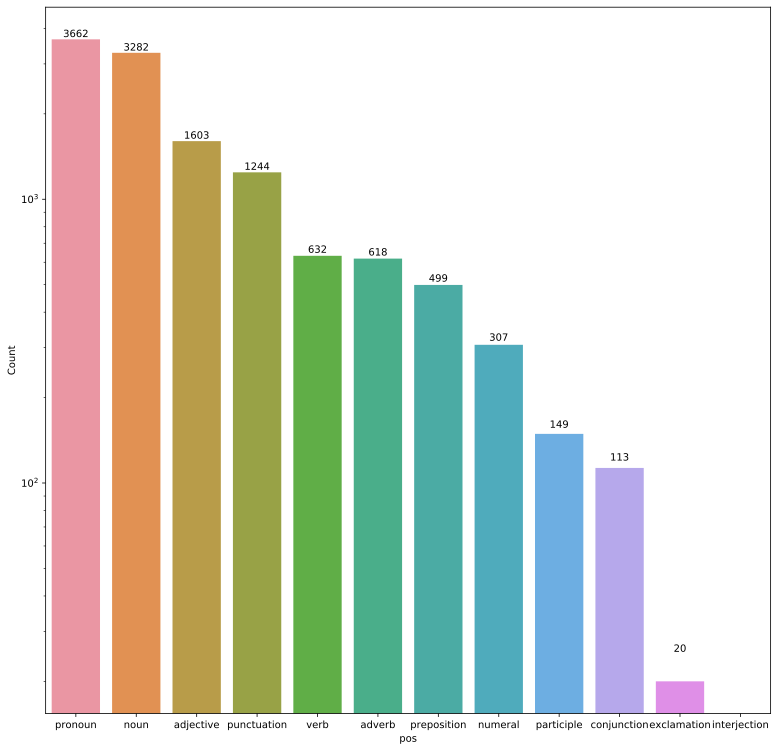

In [136]:
f, ax = plt.subplots(figsize=(13, 13))
sns_plot = sns.barplot(x='pos', y='word', data=pos_general_sorted, order=pos_general_sorted['pos'].to_list())
# sns_plot = sns.countplot(x='pos', data=df_full) - то же самое
sns_plot.set(yscale="log")
plt.ylabel('Count')
for bar in sns_plot.patches:
        height = bar.get_height()
        if not np.isnan(height):
            height = int(height)
        if height == 0:
            continue

        ax.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{height}',
                ha='center', va='bottom')
        
print(sns_plot)



# sns_plot.savefig('pairplot.png')

In [142]:
df_full[(df_full['pos'] == 'participle') & (pd.isnull(df_full['case']))].head()

,prep,word,lemma,pos,person,number,tense,mood,voice,gender,case,degree,sentence,author,title


In [144]:
df_full[(df_full['pos'] == 'numeral')].head()

,prep,word,lemma,pos,person,number,tense,mood,voice,gender,case,degree,sentence,author,title
110,e,tribus,tres,numeral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Divisa itaque perpensis meritis et laboribus p...,ammianus marcellinus.,Rerum Gestarum
69,pro,decem,decem,numeral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"si triginta annos pro decem dixisses, posses u...",apuleius,Apologia
80,cum,septem,septem,numeral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"quae si omnia affatim retudi, si calumnias omn...",apuleius,Apologia
18,ex,septem,septem,numeral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thales Milesius ex septem illis sapientiae mem...,apuleius,Florida
3,a,decem,decem,numeral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"An ignoras, inepte, nudum nec a decem palaestr...",apuleius,Metamorphoses


In [207]:
def groupby_and_plot_by_pars(filter_col, filter_col_values, group_on, aggr_on, df=df_full, plot_null=False, want_plot=True):
    if not filter_col or not filter_col_values:
        df_fragment = df
    else:
        df_fragment = df[df[filter_col] == filter_col_values]
        
    grouped_df_for_col = df_fragment.groupby(group_on, as_index=False)[aggr_on].count()
    
    sorted_groups = grouped_df_for_col.sort_values([aggr_on], ascending=False).reset_index(drop=True)
    if not plot_null:
        sorted_groups = sorted_groups[sorted_groups[aggr_on] != 0]
    print(f'Groupping df_full where "{filter_col}" only has values: "{filter_col_values}". '
          f'Groupping by "{group_on}". (aggregation by "{aggr_on}")\n\n', sorted_groups, '\n')
    
    if not want_plot:
        return
    
    f, ax = plt.subplots(figsize=(15, 15))
    groupon_values = sns.barplot(x=group_on, y=aggr_on, 
                                 data=sorted_groups, order=sorted_groups[group_on].to_list())
    groupon_values.set(yscale="log")
    plt.ylabel('Count')
    plt.title(f'Number of {filter_col_values}s by {group_on}')
    
    for bar in groupon_values.patches:
            height = bar.get_height()
            if not np.isnan(height):
                height = int(height)
            if height == 0:
                continue

#             ax.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{height}',
#                     ha='center', va='bottom')
            ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom')

    print(groupon_values)
    plt.savefig(f'graphics/boxplot_{filter_col}={filter_col_values}_{group_on}.png')

Groupping df_full where "pos" only has values: "pronoun". Groupping by "case". (aggregation by "word")

          case  word
0  accusative  2557
1    genitive   606
2  nominative   381
3      dative   109 

AxesSubplot(0.125,0.125;0.775x0.755)
Groupping df_full where "pos" only has values: "noun". Groupping by "case". (aggregation by "word")

          case  word
0    genitive   992
1      dative   967
2  nominative   883
3  accusative   357
4    vocative    66
5    locative     1 

AxesSubplot(0.125,0.125;0.775x0.755)
Groupping df_full where "pos" only has values: "adjective". Groupping by "case". (aggregation by "word")

          case  word
0  nominative   639
1  accusative   484
2    genitive   237
3      dative   228
4    vocative     5 

AxesSubplot(0.125,0.125;0.775x0.755)
Groupping df_full where "pos" only has values: "participle". Groupping by "case". (aggregation by "word")

          case  word
0  nominative    74
1      dative    59
2  accusative    14
3    genitive     2 


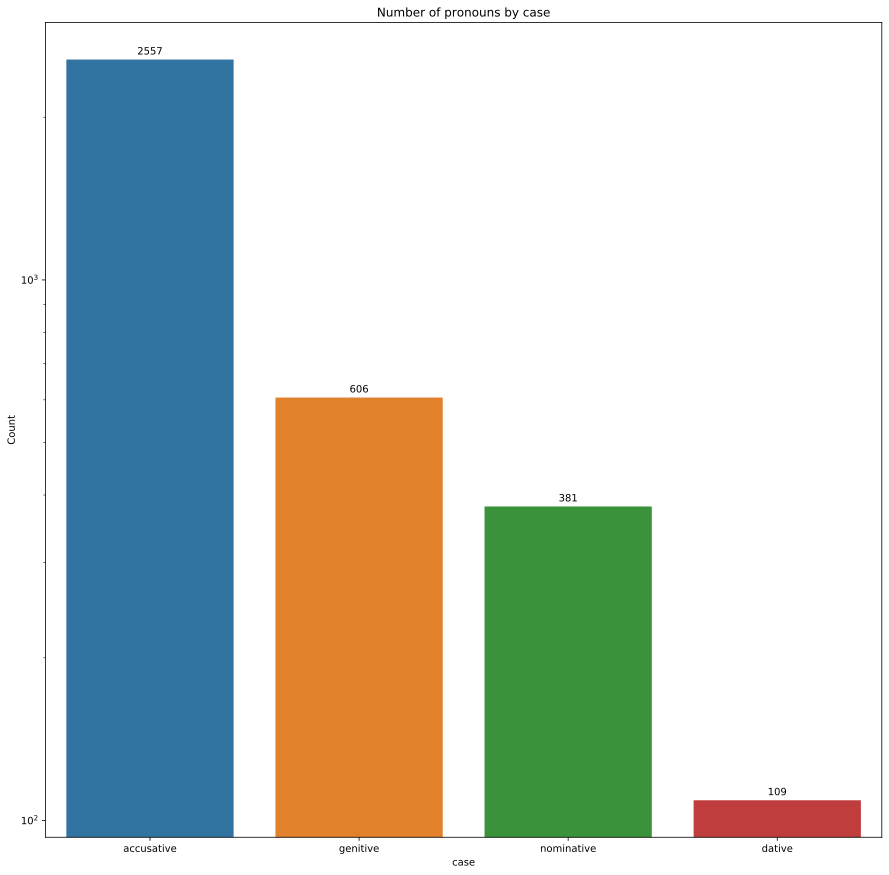

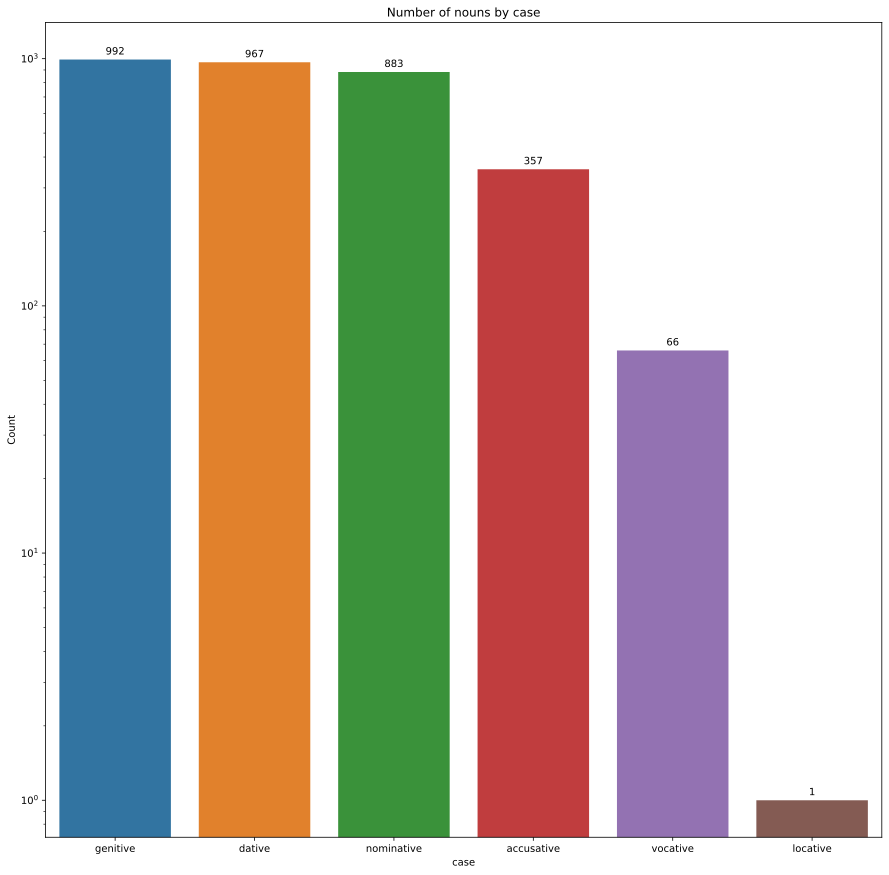

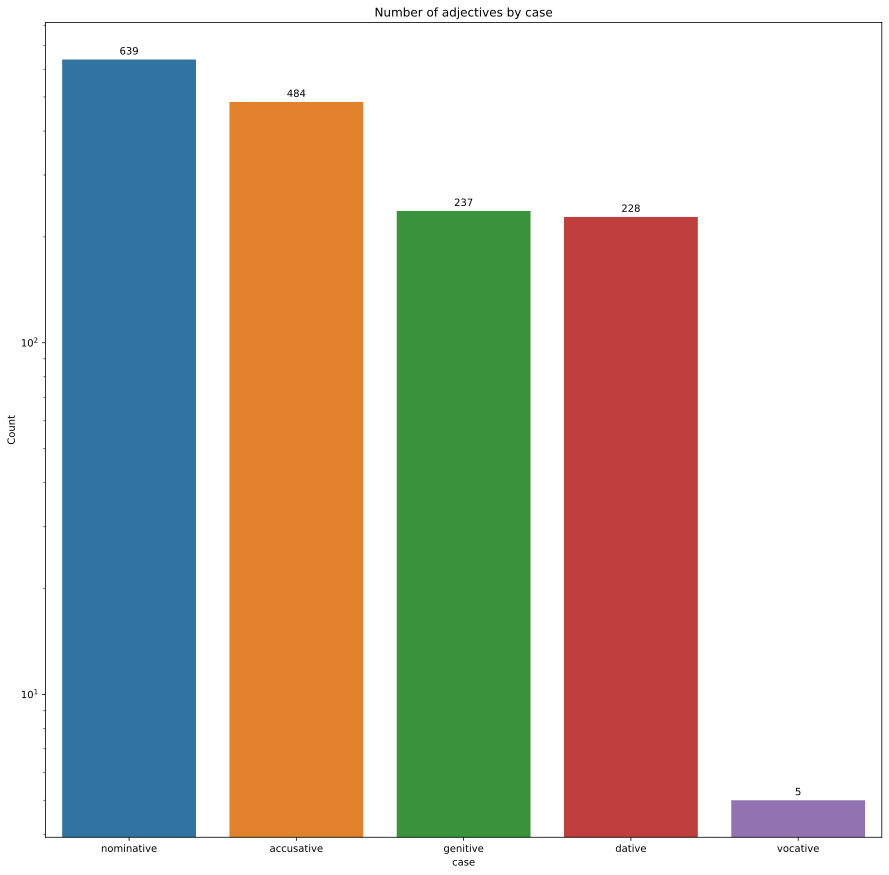

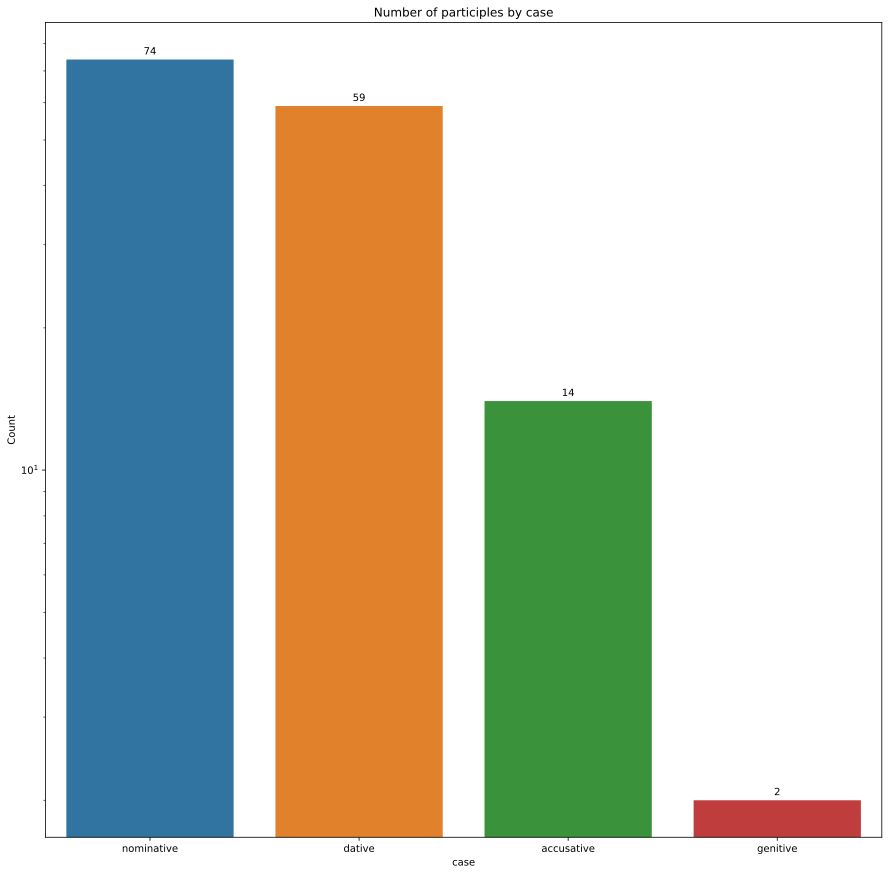

In [208]:
pos_with_case = ['pronoun', 'noun', 'adjective', 'participle']
for pos in pos_with_case:
    groupby_and_plot_by_pars('pos', pos, 'case', 'word', plot_null=False)

In [201]:
df_for_case = df_full[pd.notnull(df_full['case'])][['prep', 'case', 'word']]

In [ ]:
# groupby_and_plot_by_pars(None, None, ['prep', 'case'], 'word', df=df_for_case)

In [197]:
df_by_prep = df_full[['prep', 'case', 'word']].groupby(['prep', 'case'], as_index=False)['word'].count()
df_by_prep

,prep,case,word
0,a,nominative,218.0
1,a,genitive,155.0
2,a,dative,425.0
3,a,accusative,1104.0
4,a,ablative,NaN
...,...,...,...
58,sine,dative,75.0
59,sine,accusative,101.0
60,sine,ablative,NaN
61,sine,vocative,1.0


In [199]:
df_by_prep_no_nan = df_by_prep[pd.notnull(df_by_prep['word'])]
df_by_prep_no_nan

,prep,case,word
0,a,nominative,218.0
1,a,genitive,155.0
2,a,dative,425.0
3,a,accusative,1104.0
5,a,vocative,7.0
...,...,...,...
56,sine,nominative,250.0
57,sine,genitive,93.0
58,sine,dative,75.0
59,sine,accusative,101.0


In [191]:
first_lev = df_full[df_full['prep'] == 'cum'][['case', 'word']]
first_lev.head()

,case,word
10,genitive,militis
19,accusative,haec
28,NaN,contra
29,NaN,interdum
42,NaN,primum


In [192]:
first_lev.groupby(['case'], as_index=False)['word'].count()

,case,word
0,nominative,282
1,genitive,123
2,dative,114
3,accusative,396
4,ablative,0
5,vocative,6
6,locative,1
